In [1]:
%reload_ext autoreload
%autoreload 2

# Get msmt err dict

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [3]:
from Scratch import load_calibration_memory

DEVICE = 'ibm_sherbrooke'
DATE = '2024-03-24'

all_mmrs, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=DATE,
                                                            double_msmt=True, post_process=True)

Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 10:46:40.066413+00:00.


In [4]:
print(msmt_err_dict)

# get mean of the msmt errors
p_soft_mean = 0
p_hard_mean = 0
for key, value in msmt_err_dict.items():
    p_soft_mean += value['p_soft']
    p_hard_mean += value['p_hard']
p_soft_mean /= len(msmt_err_dict)
p_hard_mean /= len(msmt_err_dict)

print(f"p_soft_mean: {p_soft_mean}")
print(f"p_hard_mean: {p_hard_mean}")

{0: {'p_hard': 0.004889509779019557, 'p_soft': 9.5250190500381e-05}, 1: {'p_hard': 0.004826009652019304, 'p_soft': 0.005143510287020574}, 2: {'p_hard': 0.013398526797053594, 'p_soft': 0.013049276098552196}, 3: {'p_hard': 0.006159512319024637, 'p_soft': 0.0012700025400050798}, 4: {'p_hard': 0.007207264414528829, 'p_soft': 0.0016827533655067312}, 5: {'p_hard': 0.011366522733045465, 'p_soft': 0.03349631699263399}, 6: {'p_hard': 0.018954787909575818, 'p_soft': 0.01936753873507747}, 7: {'p_hard': 0.007048514097028193, 'p_soft': 0.0013970027940055881}, 8: {'p_hard': 0.006318262636525273, 'p_soft': 0.03273431546863094}, 9: {'p_hard': 0.026638303276606552, 'p_soft': 0.01660528321056642}, 10: {'p_hard': 0.004730759461518923, 'p_soft': 0.0028257556515113033}, 11: {'p_hard': 0.007429514859029719, 'p_soft': 0.00158750317500635}, 12: {'p_hard': 0.014509779019558038, 'p_soft': 0.01908178816357633}, 13: {'p_hard': 0.008382016764033528, 'p_soft': 0.02867030734061468}, 14: {'p_hard': 0.0146367792735585

# Create stim circuit

In [21]:
msmt_err_dict = {
    0: {'p_soft': 0.0, 'p_hard': 0.09},
    1: {'p_soft': 0.18, 'p_hard': 0.19},
    2: {'p_soft': 0.28, 'p_hard': 0.29},
    3: {'p_soft': 0.38, 'p_hard': 0.39},
    4: {'p_soft': 0.48, 'p_hard': 0.49},
}

In [23]:
from soft_info import RepetitionCodeStimCircuit

d = 3
T = 2
resets = False
xbasis = False
logical = '0'
subsampling = True

s_m = 0.5
noise_list = [2e-2, 1e-3, 0.2e-2, 0.5e-2, 2e-2, 2e-2*(1-s_m), 2e-2*s_m] # [twog_err, sglg_err, t1_err, t2_err, readout_err, hard_err, soft_err]
noise_list[-2:] = [p_hard_mean, p_soft_mean]
# noise_list = None

layout = [1, 3, 0, 2, 4]

code = RepetitionCodeStimCircuit(d, T, xbasis=xbasis, resets=resets, noise_list=noise_list, 
                                 subsampling=subsampling, msmt_err_dict=msmt_err_dict, layout=layout,
                                 no_fin_soft=True)

circuit = code.circuits[logical]
print(circuit)

R 0 1 2 3 4
TICK
X_ERROR(0.001) 0 2 4
Y_ERROR(0.001) 0 2 4
Z_ERROR(0.005) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.02) 0 1 2 3
DEPOLARIZE1(0.02) 4
TICK
CX 2 1 4 3
DEPOLARIZE2(0.02) 2 1 4 3
DEPOLARIZE1(0.02) 0
TICK
X_ERROR(0.19) 1
M(0.18) 1
X_ERROR(0.39) 3
M(0.38) 3
DETECTOR(2, 0) rec[-2]
DETECTOR(4, 0) rec[-1]
SHIFT_COORDS(0, 1)
X_ERROR(0.001) 0 2 4
Y_ERROR(0.001) 0 2 4
Z_ERROR(0.005) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.02) 0 1 2 3
DEPOLARIZE1(0.02) 4
TICK
CX 2 1 4 3
DEPOLARIZE2(0.02) 2 1 4 3
DEPOLARIZE1(0.02) 0
TICK
X_ERROR(0.19) 1
M(0.18) 1
X_ERROR(0.39) 3
M(0.38) 3
DETECTOR(2, 0) rec[-2]
DETECTOR(4, 0) rec[-1]
SHIFT_COORDS(0, 1)
X_ERROR(0.09) 0
M(0) 0
X_ERROR(0.29) 2
M(0) 2
X_ERROR(0.49) 4
M(0) 4
DETECTOR(2, 0) rec[-3] rec[-2] rec[-5] rec[-7]
DETECTOR(4, 0) rec[-2] rec[-1] rec[-4] rec[-6]
OBSERVABLE_INCLUDE(0) rec[-1]


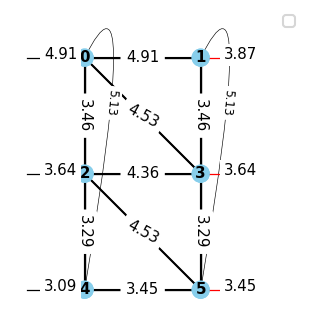

In [10]:
import pymatching
from soft_info import draw_matching_graph

model = circuit.detector_error_model()
matching = pymatching.Matching.from_detector_error_model(model)

draw_matching_graph(matching, d, T, figsize=(2,2), scale_factor=0.6)